In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent))
str(Path.cwd().parent)

'/home/ubuntu/varios/skforecast'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# set theme for matplotlib
plt.style.use('seaborn-v0_8-darkgrid')

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDiff import ForecasterAutoregDiff
from sklearn.linear_model import LinearRegression   
from sklearn.ensemble import RandomForestRegressor
from lineartree import LinearForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from skforecast.preprocessing import TimeSeriesDifferentiator

Train dates : 1991-07-01 00:00:00 --- 2003-03-01 00:00:00  (n=141)
Test dates  : 2003-04-01 00:00:00 --- 2008-06-01 00:00:00  (n=63)


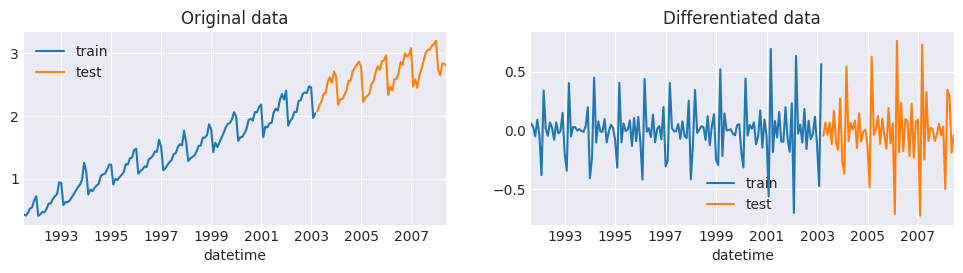

In [13]:
# Download data
# ==============================================================================
url = (
    'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/'
    'data/h2o.csv'
)
data = pd.read_csv(url, sep=',', header=0, names=['y', 'datetime'])

# Data preprocessing
# ==============================================================================
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
data = data['y']
data = data.sort_index()

# Add a smooth positive trend
# ==============================================================================
t = np.arange(len(data))
data = data + 0.01 * t

# Data differentiated
# ==============================================================================
diferenciator = TimeSeriesDifferentiator(order=2)
data_diff = diferenciator.fit_transform(data)
data_diff = pd.Series(data_diff, index=data.index).dropna()

# Data partition train-test
# ==============================================================================
end_train = '2003-03-01 23:59:00'
print(
    f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}  " 
    f"(n={len(data.loc[:end_train])})")
print(
    f"Test dates  : {data.loc[end_train:].index.min()} --- {data.index.max()}  "
    f"(n={len(data.loc[end_train:])})")

# Plot
# ==============================================================================
fig, axs = plt.subplots(1, 2, figsize=(12, 2.5))
axs = axs.ravel()
data.loc[:end_train].plot(ax=axs[0], label='train')
data.loc[end_train:].plot(ax=axs[0], label='test')
axs[0].legend()
axs[0].set_title('Original data')

data_diff.loc[:end_train].plot(ax=axs[1], label='train')
data_diff.loc[end_train:].plot(ax=axs[1], label='test')
axs[1].legend()
axs[1].set_title('Differentiated data');

In [21]:
data.diff().diff().head(18)

datetime
1991-07-01         NaN
1991-08-01         NaN
1991-09-01    0.060142
1991-10-01    0.029131
1991-11-01   -0.050558
1991-12-01    0.090457
1992-01-01   -0.042816
1992-02-01   -0.381366
1992-03-01    0.339027
1992-04-01    0.013332
1992-05-01   -0.046467
1992-06-01    0.066740
1992-07-01    0.024122
1992-08-01   -0.080780
1992-09-01    0.067223
1992-10-01   -0.025453
1992-11-01   -0.007228
1992-12-01    0.149417
Freq: MS, Name: y, dtype: float64

In [19]:
y_train_1

datetime
1992-12-01    0.149417
1993-01-01   -0.195789
1993-02-01   -0.344193
1993-03-01    0.403677
1993-04-01   -0.053122
                ...   
2002-11-01   -0.033959
2002-12-01    0.116160
2003-01-01   -0.120611
2003-02-01   -0.475218
2003-03-01    0.564886
Freq: MS, Name: y, Length: 124, dtype: float64

In [22]:
y_train_2

datetime
1992-11-01    0.036617
1992-12-01    0.186034
1993-01-01   -0.009755
1993-02-01   -0.353948
1993-03-01    0.049729
                ...   
2002-11-01   -0.010180
2002-12-01    0.105980
2003-01-01   -0.014631
2003-02-01   -0.489849
2003-03-01    0.075037
Freq: MS, Name: y, Length: 125, dtype: float64

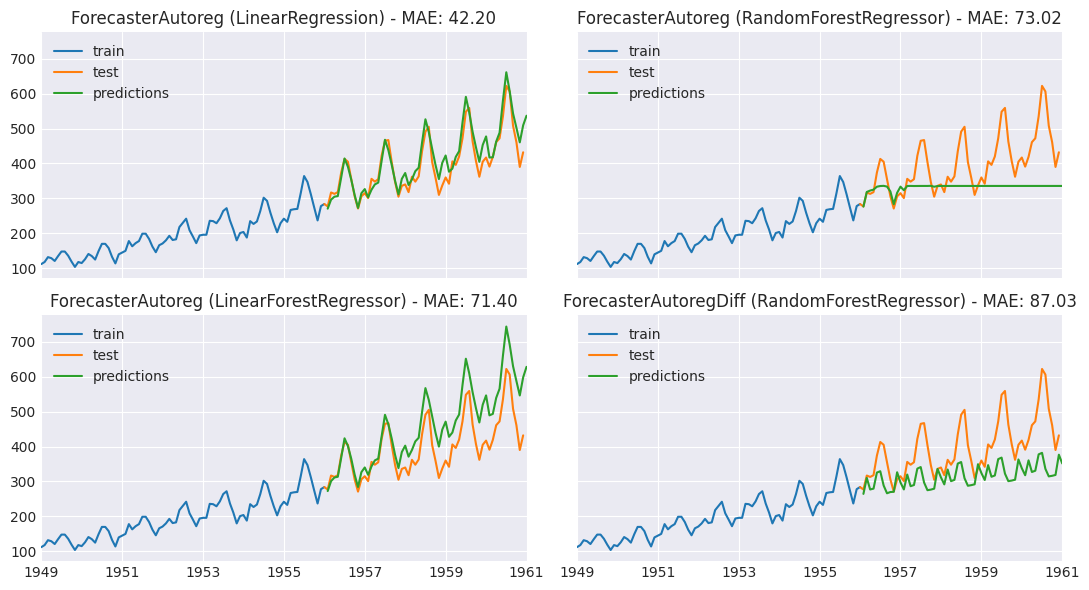

In [12]:
# Compare predictions of different models
# ==============================================================================
regressors = [
    LinearRegression(),
    RandomForestRegressor(random_state=123),
    LinearForestRegressor(base_estimator=LinearRegression(), max_features='sqrt')
]
steps = len(data.loc[end_train:])

fig, ax = plt.subplots(2, 2, figsize=(11, 6), sharex=True, sharey=True)
ax = ax.ravel()
# ForecasterAutoreg
for i, regressor in enumerate(regressors):
    forecaster = ForecasterAutoreg(
        regressor=regressor,
        lags=15
    )
    forecaster.fit(y=data.loc[:end_train])
    predictions = forecaster.predict(steps=steps)
    error = mean_absolute_error(data.loc[end_train:], predictions)
    data.loc[:end_train].plot(ax=ax[i], label='train')
    data.loc[end_train:].plot(ax=ax[i], label='test')
    predictions.plot(ax=ax[i], label='predictions')
    ax[i].set_title(
        f'ForecasterAutoreg ({forecaster.regressor.__class__.__name__}) - MAE: {error:.2f}',
        size=12
    )
    ax[i].set_xlabel('')
    ax[i].legend()

# ForecasterAutoregDiff with random forest
forecaster = ForecasterAutoregDiff(
                 regressor       = RandomForestRegressor(random_state=963),
                 lags            = 15,
                 differentiation = 2
            )
forecaster.fit(y=data.loc[:end_train])
predictions = forecaster.predict(steps=steps)
error = mean_absolute_error(data.loc[end_train:], predictions)
data.loc[:end_train].plot(ax=ax[3], label='train')
data.loc[end_train:].plot(ax=ax[3], label='test')
predictions.plot(ax=ax[3], label='predictions')
ax[3].set_title(
        f'ForecasterAutoregDiff ({forecaster.regressor.__class__.__name__}) - MAE: {error:.2f}',
        size=12
    )
ax[3].set_xlabel('')
ax[3].legend()

fig.tight_layout()

Series differentiated before training
-------------------------------------
Last window of training series: datetime
2002-01-01    0.230831
2002-02-01   -0.703838
2002-03-01    0.635863
2002-04-01   -0.026883
2002-05-01    0.049379
2002-06-01   -0.103919
2002-07-01    0.181810
2002-08-01   -0.159664
2002-09-01    0.082526
2002-10-01   -0.075052
2002-11-01   -0.033959
2002-12-01    0.116160
2003-01-01   -0.120611
2003-02-01   -0.475218
2003-03-01    0.564886
Freq: MS, dtype: float64
Train matrix


,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15
datetime,,,,,,,,,,,,,,,
1992-12-01,-0.007228,-0.025453,0.067223,-0.080780,0.024122,0.066740,-0.046467,0.013332,0.339027,-0.381366,-0.042816,0.090457,-0.050558,0.029131,0.060142
1993-01-01,0.149417,-0.007228,-0.025453,0.067223,-0.080780,0.024122,0.066740,-0.046467,0.013332,0.339027,-0.381366,-0.042816,0.090457,-0.050558,0.029131
1993-02-01,-0.195789,0.149417,-0.007228,-0.025453,0.067223,-0.080780,0.024122,0.066740,-0.046467,0.013332,0.339027,-0.381366,-0.042816,0.090457,-0.050558


Predictions


2003-04-01   -0.094748
2003-05-01    0.086311
2003-06-01   -0.058309
2003-07-01    0.107984
2003-08-01   -0.101326
2003-09-01    0.025146
2003-10-01    0.019928
2003-11-01    0.012007
2003-12-01    0.115069
2004-01-01   -0.198038
2004-02-01   -0.393918
2004-03-01    0.460809
2004-04-01   -0.090236
2004-05-01    0.062683
2004-06-01   -0.037092
2004-07-01    0.063192
2004-08-01   -0.092176
2004-09-01    0.057199
2004-10-01   -0.059114
2004-11-01    0.020669
2004-12-01    0.127037
2005-01-01   -0.253554
2005-02-01   -0.342264
2005-03-01    0.445786
2005-04-01   -0.100377
2005-05-01    0.068766
2005-06-01   -0.030057
2005-07-01    0.046360
2005-08-01   -0.026267
2005-09-01    0.029245
2005-10-01   -0.018021
2005-11-01    0.039556
2005-12-01    0.109680
2006-01-01   -0.280205
2006-02-01   -0.305197
2006-03-01    0.424686
2006-04-01   -0.088773
2006-05-01    0.070054
2006-06-01   -0.036320
2006-07-01    0.051135
2006-08-01   -0.075547
2006-09-01    0.060936
2006-10-01   -0.085702
2006-11-01 

2003-04-01    1.948586
2003-05-01    2.034897
2003-06-01    1.976588
2003-07-01    2.084572
2003-08-01    1.983246
2003-09-01    2.008392
2003-10-01    2.028320
2003-11-01    2.040327
2003-12-01    2.155395
2004-01-01    1.957358
2004-02-01    1.563440
2004-03-01    2.024248
2004-04-01    1.934012
2004-05-01    1.996695
2004-06-01    1.959603
2004-07-01    2.022795
2004-08-01    1.930619
2004-09-01    1.987818
2004-10-01    1.928704
2004-11-01    1.949373
2004-12-01    2.076410
2005-01-01    1.822856
2005-02-01    1.480592
2005-03-01    1.926378
2005-04-01    1.826000
2005-05-01    1.894767
2005-06-01    1.864710
2005-07-01    1.911070
2005-08-01    1.884803
2005-09-01    1.914049
2005-10-01    1.896027
2005-11-01    1.935583
2005-12-01    2.045263
2006-01-01    1.765058
2006-02-01    1.459861
2006-03-01    1.884547
2006-04-01    1.795773
2006-05-01    1.865827
2006-06-01    1.829507
2006-07-01    1.880642
2006-08-01    1.805095
2006-09-01    1.866031
2006-10-01    1.780328
2006-11-01 


Series differentiated during training
-------------------------------------
Last window of training series: datetime
2001-12-01    2.262313
2002-01-01    2.405868
2002-02-01    1.845584
2002-03-01    1.921165
2002-04-01    1.969862
2002-05-01    2.067938
2002-06-01    2.062096
2002-07-01    2.238064
2002-08-01    2.254368
2002-09-01    2.353198
2002-10-01    2.376976
2002-11-01    2.366796
2002-12-01    2.472776
2003-01-01    2.458145
2003-02-01    1.968296
2003-03-01    2.043333
Freq: MS, Name: y, dtype: float64
Train matrix


,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15
datetime,,,,,,,,,,,,,,,
1992-11-01,0.043845,0.069298,0.002075,0.082855,0.058733,-0.008007,0.038460,0.025128,-0.313899,0.067467,0.110283,0.019826,0.070384,0.041253,-0.018889
1992-12-01,0.036617,0.043845,0.069298,0.002075,0.082855,0.058733,-0.008007,0.038460,0.025128,-0.313899,0.067467,0.110283,0.019826,0.070384,0.041253
1993-01-01,0.186034,0.036617,0.043845,0.069298,0.002075,0.082855,0.058733,-0.008007,0.038460,0.025128,-0.313899,0.067467,0.110283,0.019826,0.070384


Predictions


2003-04-01    2.060425
2003-05-01    2.145934
2003-06-01    2.176551
2003-07-01    2.303930
2003-08-01    2.305844
2003-09-01    2.410863
2003-10-01    2.424657
2003-11-01    2.484868
2003-12-01    2.586600
2004-01-01    2.567780
2004-02-01    2.136349
2004-03-01    2.229784
2004-04-01    2.206811
2004-05-01    2.282616
2004-06-01    2.316278
2004-07-01    2.439467
2004-08-01    2.459641
2004-09-01    2.528251
2004-10-01    2.560923
2004-11-01    2.620220
2004-12-01    2.699663
2005-01-01    2.704686
2005-02-01    2.283487
2005-03-01    2.370611
2005-04-01    2.358061
2005-05-01    2.420094
2005-06-01    2.449216
2005-07-01    2.574530
2005-08-01    2.596654
2005-09-01    2.637595
2005-10-01    2.679847
2005-11-01    2.728379
2005-12-01    2.800064
2006-01-01    2.840384
2006-02-01    2.410247
2006-03-01    2.493872
2006-04-01    2.497122
2006-05-01    2.559401
2006-06-01    2.586935
2006-07-01    2.711475
2006-08-01    2.732836
2006-09-01    2.760908
2006-10-01    2.808913
2006-11-01 

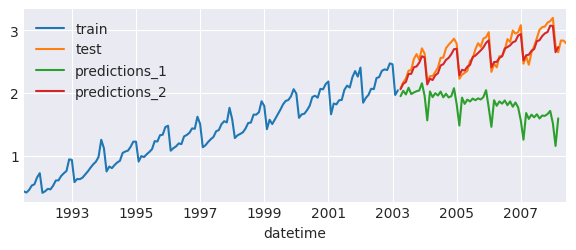

In [14]:
# Comparasion of results if the time series is differenciated before training or during the training
# =================================================================================================
print("Series differentiated before training")
print("-------------------------------------")
forecaster_1 = ForecasterAutoregDiff(
                 regressor = RandomForestRegressor(random_state=963),
                 lags      = 15
             )

forecaster_1.fit(y=data_diff.loc[:end_train])
last_window_1 = forecaster_1.last_window
print(f"Last window of training series: {last_window_1}")
print("Train matrix")
X_train_1, y_train_1 = forecaster_1.create_train_X_y(data_diff.loc[:end_train])
display(X_train_1.head(3))
predictions_diff = forecaster_1.predict(steps=steps)
last_value_train = data.loc[:end_train].iloc[[-1]]
predictions_1 = pd.concat([last_value_train, predictions_diff]).cumsum()[1:]
print("Predictions")
display(predictions_diff)
display(predictions_1)
print("")

print("Series differentiated during training")
print("-------------------------------------")
forecaster_2 = ForecasterAutoregDiff(
                 regressor = RandomForestRegressor(random_state=963),
                 lags      = 15,
                 differentiation = 1
             )

forecaster_2.fit(y=data.loc[:end_train])
last_window_2 = forecaster_2.last_window
print(f"Last window of training series: {last_window_2}")
print("Train matrix")
X_train_2, y_train_2 = forecaster_2.create_train_X_y(data.loc[:end_train])
display(X_train_2.head(3))
predictions_2 = forecaster_2.predict(steps=steps)
print("Predictions")
display(predictions_2)

fig, ax = plt.subplots(figsize=(7, 2.5))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='test')
predictions_1.plot(ax=ax, label='predictions_1')
predictions_2.plot(ax=ax, label='predictions_2')
ax.legend();


In [6]:
pd.testing.assert_series_equal(predictions_1.asfreq('MS'), predictions_2, check_names=False)

In [15]:
X_train_1

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15
datetime,,,,,,,,,,,,,,,
1992-12-01,-0.007228,-0.025453,0.067223,-0.080780,0.024122,0.066740,-0.046467,0.013332,0.339027,-0.381366,-0.042816,0.090457,-0.050558,0.029131,0.060142
1993-01-01,0.149417,-0.007228,-0.025453,0.067223,-0.080780,0.024122,0.066740,-0.046467,0.013332,0.339027,-0.381366,-0.042816,0.090457,-0.050558,0.029131
1993-02-01,-0.195789,0.149417,-0.007228,-0.025453,0.067223,-0.080780,0.024122,0.066740,-0.046467,0.013332,0.339027,-0.381366,-0.042816,0.090457,-0.050558
1993-03-01,-0.344193,-0.195789,0.149417,-0.007228,-0.025453,0.067223,-0.080780,0.024122,0.066740,-0.046467,0.013332,0.339027,-0.381366,-0.042816,0.090457
1993-04-01,0.403677,-0.344193,-0.195789,0.149417,-0.007228,-0.025453,0.067223,-0.080780,0.024122,0.066740,-0.046467,0.013332,0.339027,-0.381366,-0.042816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002-11-01,-0.075052,0.082526,-0.159664,0.181810,-0.103919,0.049379,-0.026883,0.635863,-0.703838,0.230831,-0.182574,-0.071551,0.197109,-0.096040,-0.096716
2002-12-01,-0.033959,-0.075052,0.082526,-0.159664,0.181810,-0.103919,0.049379,-0.026883,0.635863,-0.703838,0.230831,-0.182574,-0.071551,0.197109,-0.096040
2003-01-01,0.116160,-0.033959,-0.075052,0.082526,-0.159664,0.181810,-0.103919,0.049379,-0.026883,0.635863,-0.703838,0.230831,-0.182574,-0.071551,0.197109


In [16]:
X_train_2

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15
datetime,,,,,,,,,,,,,,,
1992-11-01,0.043845,0.069298,0.002075,0.082855,0.058733,-0.008007,0.038460,0.025128,-0.313899,0.067467,0.110283,0.019826,0.070384,0.041253,-0.018889
1992-12-01,0.036617,0.043845,0.069298,0.002075,0.082855,0.058733,-0.008007,0.038460,0.025128,-0.313899,0.067467,0.110283,0.019826,0.070384,0.041253
1993-01-01,0.186034,0.036617,0.043845,0.069298,0.002075,0.082855,0.058733,-0.008007,0.038460,0.025128,-0.313899,0.067467,0.110283,0.019826,0.070384
1993-02-01,-0.009755,0.186034,0.036617,0.043845,0.069298,0.002075,0.082855,0.058733,-0.008007,0.038460,0.025128,-0.313899,0.067467,0.110283,0.019826
1993-03-01,-0.353948,-0.009755,0.186034,0.036617,0.043845,0.069298,0.002075,0.082855,0.058733,-0.008007,0.038460,0.025128,-0.313899,0.067467,0.110283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002-11-01,0.023778,0.098830,0.016304,0.175968,-0.005842,0.098076,0.048697,0.075580,-0.560283,0.143554,-0.087277,0.095297,0.166848,-0.030261,0.065779
2002-12-01,-0.010180,0.023778,0.098830,0.016304,0.175968,-0.005842,0.098076,0.048697,0.075580,-0.560283,0.143554,-0.087277,0.095297,0.166848,-0.030261
2003-01-01,0.105980,-0.010180,0.023778,0.098830,0.016304,0.175968,-0.005842,0.098076,0.048697,0.075580,-0.560283,0.143554,-0.087277,0.095297,0.166848


<script src="https://kit.fontawesome.com/d20edc211b.js" crossorigin="anonymous"></script>
<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px;">
<p class="title">
    <i class="fa-triangle-exclamation fa" style="font-size: 18px; color:#ff9100;"></i>
    <b style="color: #ff9100;"> &nbsp Warning</b>
</p>

Predictions should be equal!!!!!!!!!!!!

+ Training matrices are equal

+ Predictions are not equal and start at different time

</div>

Train dates : 1949-01-01 00:00:00 --- 1956-01-01 00:00:00  (n=85)
Test dates  : 1956-01-01 00:00:00 --- 1960-12-01 00:00:00  (n=60)


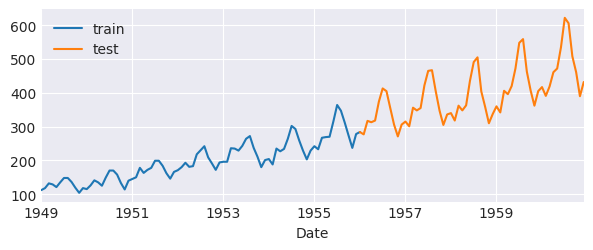

In [7]:
# Download data
# ==============================================================================
url = (
    'https://raw.githubusercontent.com/JoaquinAmatRodrigo/Estadistica-machine-learning-python/'
    'master/data/AirPassengers.csv'
)
data = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m')
data = data.set_index('Date')
data = data.asfreq('MS')
data = data['Passengers']
data = data.sort_index()


# # Data partition train-test
# # ==============================================================================
end_train = '1956-01-01'
print(
    f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}  " 
    f"(n={len(data.loc[:end_train])})")
print(
    f"Test dates  : {data.loc[end_train:].index.min()} --- {data.index.max()}  "
    f"(n={len(data.loc[end_train:])})")

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 2.5))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='test')
ax.legend();

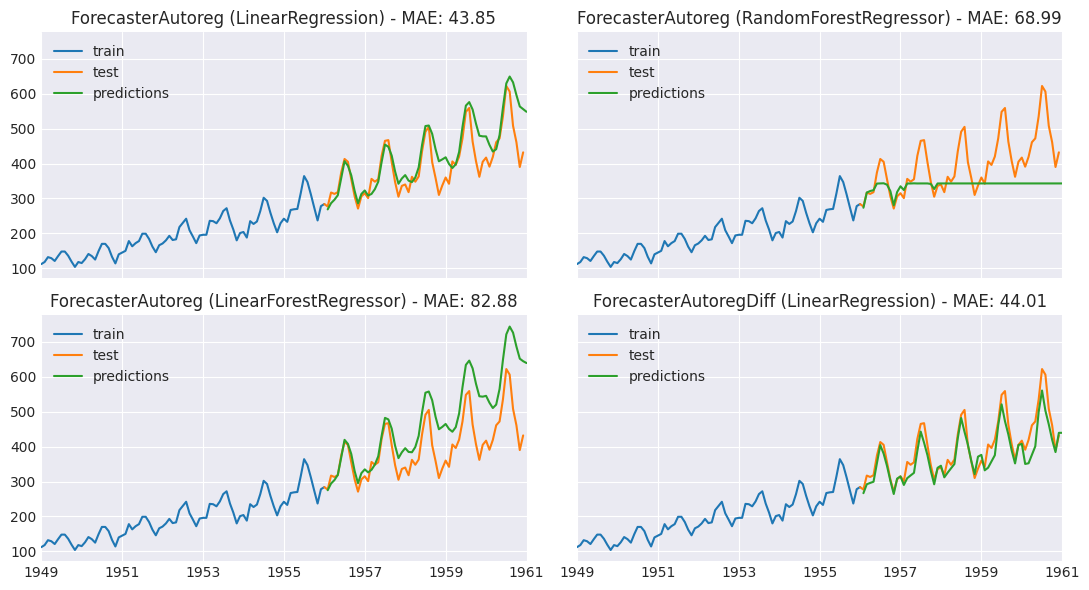

In [9]:
# Compare predictions of different models
# ==============================================================================
regressors = [
    LinearRegression(),
    RandomForestRegressor(random_state=123),
    LinearForestRegressor(base_estimator=LinearRegression(), max_features='sqrt')
]

fig, ax = plt.subplots(2, 2, figsize=(11, 6), sharex=True, sharey=True)
ax = ax.ravel()

# ForecasterAutoreg
for i, regressor in enumerate(regressors):
    forecaster = ForecasterAutoreg(
        regressor=regressor,
        lags=12
    )
    forecaster.fit(y=data.loc[:end_train])
    predictions = forecaster.predict(steps=len(data.loc[end_train:]))
    error = mean_absolute_error(data.loc[end_train:], predictions)
    data.loc[:end_train].plot(ax=ax[i], label='train')
    data.loc[end_train:].plot(ax=ax[i], label='test')
    predictions.plot(ax=ax[i], label='predictions')
    ax[i].set_title(
        f'ForecasterAutoreg ({regressor.__class__.__name__}) - MAE: {error:.2f}',
        size=12
    )
    ax[i].set_xlabel('')
    ax[i].legend()

# ForecasterAutoregDiff with random forest
forecaster = ForecasterAutoregDiff(
                 regressor       = LinearRegression(),
                 lags            = 12,
                 differentiation = 1
            )
forecaster.fit(y=data.loc[:end_train])
predictions = forecaster.predict(steps=len(data.loc[end_train:]))
error = mean_absolute_error(data.loc[end_train:], predictions)
data.loc[:end_train].plot(ax=ax[3], label='train')
data.loc[end_train:].plot(ax=ax[3], label='test')
predictions.plot(ax=ax[3], label='predictions')
ax[3].set_title(
        f'ForecasterAutoregDiff ({forecaster.regressor.__class__.__name__}) - MAE: {error:.2f}',
        size=12
    )
ax[3].set_xlabel('')
ax[3].legend()

fig.tight_layout()

/home/ubuntu/anaconda3/envs/skforecast_09_py11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


1956-02-01    275.105784
1956-03-01    299.922186
1956-04-01    307.543573
1956-05-01    312.027553
Freq: MS, Name: predicted_mean, dtype: float64

1956-02-01    268.119020
1956-03-01    307.097034
1956-04-01    287.887444
1956-05-01    282.744358
Freq: MS, Name: pred, dtype: float64

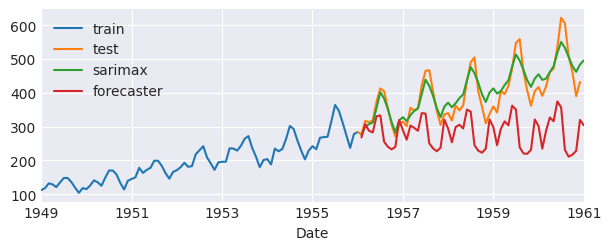

In [11]:
# Compare predictions with an arima (lags, 0, 0)
# ==============================================================================
from statsmodels.tsa.statespace.sarimax import SARIMAX
steps = len(data.loc[end_train:])

sarimax = SARIMAX(data.loc[:end_train], order=(12, 2, 0))
res_sarimax = sarimax.fit(disp=False, maxiter=1000)
predictions_sarimax = res_sarimax.get_forecast(steps).predicted_mean
display(predictions_sarimax.head(4))

forecaster = ForecasterAutoregDiff(
                 regressor       = LinearRegression(),
                 lags            = 12,
                 differentiation = 2
            )
            
forecaster.fit(y=data.loc[:end_train])
predictions = forecaster.predict(steps=steps)
display(predictions.head(4))

fig, ax = plt.subplots(figsize=(7, 2.5))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='test')
predictions_sarimax.plot(ax=ax, label='sarimax')
predictions.plot(ax=ax, label='forecaster')
ax.legend();


In [9]:
# Bootstrapping predictions
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor=RandomForestRegressor(random_state=123),
                lags=12
            )
forecaster.fit(y=data.loc[:end_train])
boo_predictions = forecaster.predict_bootstrapping(
                        steps=len(data.loc[end_train:]),
                        n_boot=10
)
boo_predictions

,pred_boot_0,pred_boot_1,pred_boot_2,pred_boot_3,pred_boot_4,pred_boot_5,pred_boot_6,pred_boot_7,pred_boot_8,pred_boot_9
1955-02-01,215.52,215.96,219.37,213.68,214.17,218.90,212.89,208.10,207.80,208.00
1955-03-01,240.30,231.22,247.84,231.12,231.12,239.22,241.95,230.58,233.49,241.95
1955-04-01,237.40,239.72,247.98,230.45,230.45,232.57,243.64,244.61,242.52,238.94
1955-05-01,250.51,250.17,241.72,242.26,248.10,252.96,239.34,251.61,253.90,243.54
1955-06-01,280.46,277.86,276.45,272.02,283.78,281.86,273.32,289.50,284.49,282.77
...,...,...,...,...,...,...,...,...,...,...
1960-09-01,272.49,279.49,283.10,277.94,276.97,283.98,282.71,277.78,283.14,278.10
1960-10-01,277.43,295.64,289.20,281.71,278.91,272.49,281.16,281.51,289.20,283.25
1960-11-01,284.79,284.47,282.71,277.31,284.36,285.93,292.72,278.75,281.21,285.19
1960-12-01,283.19,283.19,293.02,296.86,276.38,282.71,279.35,289.35,284.12,284.47


In [10]:
forecaster = ForecasterAutoregDiff(
                regressor=RandomForestRegressor(random_state=123),
                lags=12,
                differentiation=1
            )
forecaster.fit(y=data.loc[:end_train])
boo_predictions = forecaster.predict_bootstrapping(
                        steps=len(data.loc[end_train:]),
                        n_boot=10
)
boo_predictions

,pred_boot_0,pred_boot_1,pred_boot_2,pred_boot_3,pred_boot_4,pred_boot_5,pred_boot_6,pred_boot_7,pred_boot_8,pred_boot_9
1955-02-01,183.80,186.38,180.74,184.33,180.74,186.97,184.33,182.45,184.19,185.36
1955-03-01,231.50,233.27,235.48,230.50,230.50,234.62,231.56,230.50,236.73,231.56
1955-04-01,198.78,193.95,192.85,199.87,198.86,195.67,196.42,202.28,202.91,205.64
1955-05-01,210.91,214.41,230.74,214.42,218.14,230.74,213.68,212.64,213.32,219.59
1955-06-01,224.76,216.94,224.11,217.16,217.84,219.97,220.28,224.66,227.12,218.93
...,...,...,...,...,...,...,...,...,...,...
1960-09-01,212.01,215.92,220.65,222.84,223.39,219.77,219.05,220.63,221.29,220.63
1960-10-01,216.29,226.40,223.41,219.62,224.49,212.01,227.18,220.15,223.41,219.54
1960-11-01,219.05,225.53,221.94,215.92,219.05,220.13,223.94,219.56,222.35,216.44
1960-12-01,220.77,220.77,223.94,229.57,217.77,221.94,218.22,234.54,219.25,225.53
